   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 21.3 MB/s eta 0:00:00


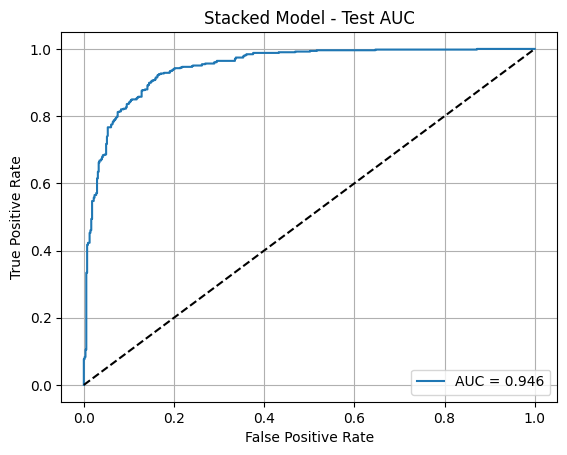

In [ ]:
# ============================== #
#   DPP-IV Inhibitor Prediction  #
#       with Stacked Model       #
# ============================== #
# Imports
!pip install rdkit
!pip install xgboost
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.MolStandardize import rdMolStandardize
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
                             matthews_corrcoef, balanced_accuracy_score, cohen_kappa_score, confusion_matrix, roc_curve, auc)
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier,
                              BaggingClassifier, StackingClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import joblib
import matplotlib.pyplot as plt
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

# ------------------------ #
# 1. Load and Filter Data  #
# ------------------------ #
df = pd.read_csv("DPPIV.csv", sep=";")
df = df[['Molecule ChEMBL ID', 'Smiles', 'Standard Type', 'Standard Relation', 'Standard Value', 'Standard Units']]
df = df.dropna()
df = df[df['Standard Units'].str.contains('nM')]
df = df[df['Standard Type'].str.contains('IC50')]
df = df[~df['Standard Type'].str.contains('pIC50|Log IC50')]
df = df.drop_duplicates(subset=['Molecule ChEMBL ID'])
df = df.sort_values('Standard Value')

# Thresholding
active = df[df['Standard Value'] <= 62].assign(label=1)
inactive = df[df['Standard Value'] >= 100].assign(label=0)
combined = pd.concat([active, inactive])
combined = combined[~combined['Standard Units'].str.contains('ug.mL-1')]
combined.to_csv("aromatase_filtered.csv", index=False)

# ---------------------------------- #
# 2. Standardize SMILES and Save     #
# ---------------------------------- #
def standardize_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        Chem.rdmolops.RemoveStereochemistry(mol)
        mol = rdMolStandardize.ChargeParent(mol)
        return Chem.MolToSmiles(mol, isomericSmiles=False)
    return None

combined['Standardized_Smiles'] = combined['Smiles'].apply(standardize_smiles)
combined.to_csv("aromatase_standardized.csv", index=False)

# ----------------------------- #
# 3. Generate Morgan Fingerprints
# ----------------------------- #
smi_df = combined[['Standardized_Smiles', 'label']]
smi_df.to_csv("aromatase.smi", index=False, header=False, sep='\t')

supplier = Chem.SmilesMolSupplier("aromatase.smi", delimiter="\t", titleLine=False)
fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048) for mol in supplier if mol]
X = np.array(fps, dtype=np.int32)
y = np.array([mol.GetProp('_Name') for mol in supplier if mol], dtype=int).reshape(-1, 1)

# -------------------- #
# 4. Split Data        #
# -------------------- #
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)

# ---------------------- #
# 5. Define ML Models    #
# ---------------------- #
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=200, learning_rate=0.1, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42),
    "Bagging": BaggingClassifier(n_estimators=50, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM": SVC(probability=True, kernel='rbf', C=10, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42),
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000, C=1.0, random_state=42)
}

# ----------------------------- #
# 6. Define Evaluation Function #
# ----------------------------- #
def calculate_metrics(y_true, y_pred, y_prob=None):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'F1-Score': f1_score(y_true, y_pred, zero_division=0),
        'ROC AUC': roc_auc_score(y_true, y_prob) if y_prob is not None else None,
        'MCC': matthews_corrcoef(y_true, y_pred),
        'Balanced Accuracy': balanced_accuracy_score(y_true, y_pred),
        'Kappa': cohen_kappa_score(y_true, y_pred),
        'Sensitivity': tp / (tp + fn) if (tp + fn) != 0 else 0,
        'Specificity': tn / (tn + fp) if (tn + fp) != 0 else 0
    }

# ---------------------------- #
# 7. Train and Evaluate Models #
# ---------------------------- #
results_train = {}
results_test = {}
trained_models = {}
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for name, model in models.items():
    model.fit(X_train, y_train.ravel())
    trained_models[name] = model
    y_train_pred = cross_val_predict(model, X_train, y_train.ravel(), cv=skf, method='predict')
    y_train_prob = (cross_val_predict(model, X_train, y_train.ravel(), cv=skf, method='predict_proba')[:, 1]
                    if hasattr(model, "predict_proba") else None)
    results_train[name] = calculate_metrics(y_train.ravel(), y_train_pred, y_train_prob)

    y_test_pred = model.predict(X_test)
    y_test_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    results_test[name] = calculate_metrics(y_test.ravel(), y_test_pred, y_test_prob)

pd.DataFrame(results_train).T.to_csv("baseline_models_train_results.csv")
pd.DataFrame(results_test).T.to_csv("baseline_models_test_results.csv")

# ---------------------------- #
# 8. Train Stacked Ensemble    #
# ---------------------------- #
base_models = [(name.replace(" ", "_"), model) for name, model in models.items()]
final_estimator = LogisticRegression(random_state=42)
stacking_classifier = StackingClassifier(estimators=base_models, final_estimator=final_estimator, cv=5, n_jobs=-1)
stacking_classifier.fit(X_train, y_train.ravel())
y_train_pred_stack = stacking_classifier.predict(X_train)
y_train_prob_stack = stacking_classifier.predict_proba(X_train)[:, 1]
y_test_pred_stack = stacking_classifier.predict(X_test)
y_test_prob_stack = stacking_classifier.predict_proba(X_test)[:, 1]

stack_train_metrics = calculate_metrics(y_train.ravel(), y_train_pred_stack, y_train_prob_stack)
stack_test_metrics = calculate_metrics(y_test.ravel(), y_test_pred_stack, y_test_prob_stack)

pd.DataFrame([stack_train_metrics, stack_test_metrics], index=['Train', 'Test']).to_csv("stacked_model_performance.csv")
joblib.dump(stacking_classifier, "stacked_classifier.pkl")

# ---------------------------- #
# 9. Plot AUC Curve            #
# ---------------------------- #
def plot_auc(y_true, y_prob, title):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {auc(fpr, tpr):.3f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

plot_auc(y_test.ravel(), y_test_prob_stack, title="Stacked Model - Test AUC")


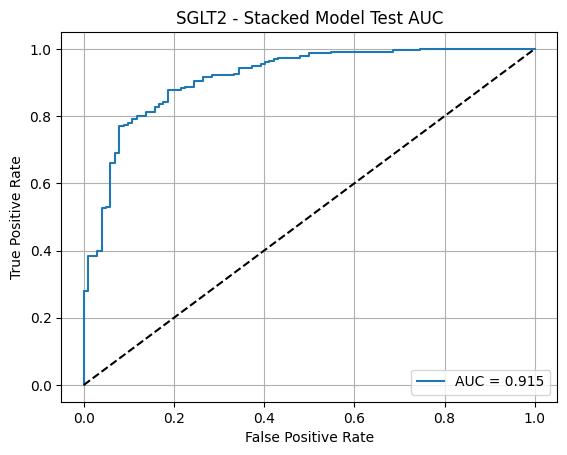

In [ ]:
# ============================== #
#   SGLT2 Inhibitor Prediction   #
#       with Stacked Model       #
# ============================== #

# Imports
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.MolStandardize import rdMolStandardize
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
                             matthews_corrcoef, balanced_accuracy_score, cohen_kappa_score, confusion_matrix, roc_curve, auc)
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier,
                              BaggingClassifier, StackingClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import joblib
import matplotlib.pyplot as plt
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

# ------------------------ #
# 1. Load and Filter Data  #
# ------------------------ #
df = pd.read_csv("Sglt2.csv", sep=";")
df = df[['Molecule ChEMBL ID', 'Smiles', 'Standard Type', 'Standard Relation', 'Standard Value', 'Standard Units']]
df = df.dropna()
df = df[df['Standard Units'].str.contains('nM')]
df = df[df['Standard Type'].str.contains('IC50')]
df = df[~df['Standard Type'].str.contains('pIC50|Log IC50')]
df = df.drop_duplicates(subset=['Molecule ChEMBL ID'])
df = df.sort_values('Standard Value')

# Thresholding (same threshold for active and inactive)
active = df[df['Standard Value'] <= 100].assign(label=1)
inactive = df[df['Standard Value'] >= 100].assign(label=0)
combined = pd.concat([active, inactive])
combined = combined[~combined['Standard Units'].str.contains('ug.mL-1')]
combined.to_csv("sglt2_filtered.csv", index=False)

# ---------------------------------- #
# 2. Standardize SMILES and Save     #
# ---------------------------------- #
def standardize_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        Chem.rdmolops.RemoveStereochemistry(mol)
        mol = rdMolStandardize.ChargeParent(mol)
        return Chem.MolToSmiles(mol, isomericSmiles=False)
    return None

combined['Standardized_Smiles'] = combined['Smiles'].apply(standardize_smiles)
combined.to_csv("sglt2_standardized.csv", index=False)

# ----------------------------- #
# 3. Generate Morgan Fingerprints
# ----------------------------- #
smi_df = combined[['Standardized_Smiles', 'label']]
smi_df.to_csv("sglt2.smi", index=False, header=False, sep='\t')

supplier = Chem.SmilesMolSupplier("sglt2.smi", delimiter="\t", titleLine=False)
fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048) for mol in supplier if mol]
X = np.array(fps, dtype=np.int32)
y = np.array([mol.GetProp('_Name') for mol in supplier if mol], dtype=int).reshape(-1, 1)

# -------------------- #
# 4. Split Data        #
# -------------------- #
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)

# ---------------------- #
# 5. Define ML Models    #
# ---------------------- #
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=200, learning_rate=0.1, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42),
    "Bagging": BaggingClassifier(n_estimators=50, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM": SVC(probability=True, kernel='rbf', C=10, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42),
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000, C=1.0, random_state=42)
}

# ----------------------------- #
# 6. Define Evaluation Function #
# ----------------------------- #
def calculate_metrics(y_true, y_pred, y_prob=None):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'F1-Score': f1_score(y_true, y_pred, zero_division=0),
        'ROC AUC': roc_auc_score(y_true, y_prob) if y_prob is not None else None,
        'MCC': matthews_corrcoef(y_true, y_pred),
        'Balanced Accuracy': balanced_accuracy_score(y_true, y_pred),
        'Kappa': cohen_kappa_score(y_true, y_pred),
        'Sensitivity': tp / (tp + fn) if (tp + fn) != 0 else 0,
        'Specificity': tn / (tn + fp) if (tn + fp) != 0 else 0
    }

# ---------------------------- #
# 7. Train and Evaluate Models #
# ---------------------------- #
results_train = {}
results_test = {}
trained_models = {}
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for name, model in models.items():
    model.fit(X_train, y_train.ravel())
    trained_models[name] = model
    y_train_pred = cross_val_predict(model, X_train, y_train.ravel(), cv=skf, method='predict')
    y_train_prob = (cross_val_predict(model, X_train, y_train.ravel(), cv=skf, method='predict_proba')[:, 1]
                    if hasattr(model, "predict_proba") else None)
    results_train[name] = calculate_metrics(y_train.ravel(), y_train_pred, y_train_prob)

    y_test_pred = model.predict(X_test)
    y_test_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    results_test[name] = calculate_metrics(y_test.ravel(), y_test_pred, y_test_prob)

pd.DataFrame(results_train).T.to_csv("sglt2_baseline_train_results.csv")
pd.DataFrame(results_test).T.to_csv("sglt2_baseline_test_results.csv")

# ---------------------------- #
# 8. Train Stacked Ensemble    #
# ---------------------------- #
base_models = [(name.replace(" ", "_"), model) for name, model in models.items()]
final_estimator = LogisticRegression(random_state=42)
stacking_classifier = StackingClassifier(estimators=base_models, final_estimator=final_estimator, cv=5, n_jobs=-1)
stacking_classifier.fit(X_train, y_train.ravel())
y_train_pred_stack = stacking_classifier.predict(X_train)
y_train_prob_stack = stacking_classifier.predict_proba(X_train)[:, 1]
y_test_pred_stack = stacking_classifier.predict(X_test)
y_test_prob_stack = stacking_classifier.predict_proba(X_test)[:, 1]

stack_train_metrics = calculate_metrics(y_train.ravel(), y_train_pred_stack, y_train_prob_stack)
stack_test_metrics = calculate_metrics(y_test.ravel(), y_test_pred_stack, y_test_prob_stack)

pd.DataFrame([stack_train_metrics, stack_test_metrics], index=['Train', 'Test']).to_csv("sglt2_stacked_performance.csv")
joblib.dump(stacking_classifier, "sglt2_stacked_model.pkl")

# ---------------------------- #
# 9. Plot AUC Curve            #
# ---------------------------- #
def plot_auc(y_true, y_prob, title):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {auc(fpr, tpr):.3f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

plot_auc(y_test.ravel(), y_test_prob_stack, title="SGLT2 - Stacked Model Test AUC")


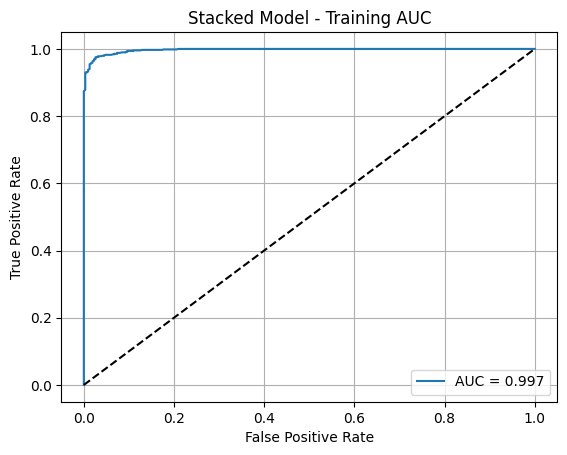

In [ ]:
# prompt: AUC for stack training plot

plot_auc(y_train.ravel(), y_train_prob_stack, title="Stacked Model - Training AUC")

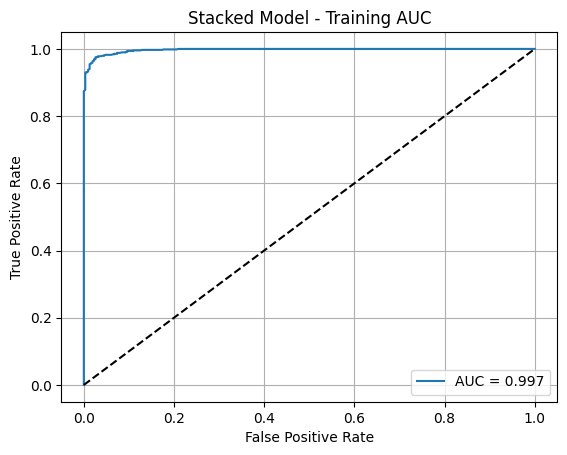

In [ ]:
# prompt: Plot AUC for Training

plot_auc(y_train.ravel(), y_train_prob_stack, title="Stacked Model - Training AUC")


In [ ]:
# prompt: develop from both stacked_classifier and sglt2_stacked_model.pkl for unknown smiles

import numpy as np
from sklearn.multioutput import MultiOutputClassifier
# Load the trained stacked models
dppiv_stacked_model = joblib.load("stacked_classifier.pkl")
sglt2_stacked_model = joblib.load("sglt2_stacked_model.pkl")

def predict_activity(smiles, dppiv_model, sglt2_model):
  """
    Predicts the activity (DPP-IV and SGLT2 inhibition) for a given SMILES string
    using pre-trained stacked models.

    Args:
      smiles (str): The SMILES string of the molecule.
      dppiv_model: The loaded trained DPP-IV stacked model.
      sglt2_model: The loaded trained SGLT2 stacked model.

    Returns:
      dict: A dictionary containing the predicted labels and probabilities for
            DPP-IV and SGLT2.
  """
  mol = Chem.MolFromSmiles(smiles)
  if mol is None:
    print(f"Could not parse SMILES: {smiles}")
    return None

  # Standardize SMILES
  standardized_smiles = standardize_smiles(smiles)
  if standardized_smiles is None:
      print(f"Could not standardize SMILES: {smiles}")
      return None

  # Generate Morgan fingerprint
  try:
    fp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(standardized_smiles), 2, nBits=2048)
    X_unknown = np.array([np.array(fp)], dtype=np.int32)
  except:
    print(f"Could not generate fingerprint for SMILES: {standardized_smiles}")
    return None


  # Predict using the DPP-IV model
  dppiv_prediction = dppiv_model.predict(X_unknown)[0]
  dppiv_probability = dppiv_model.predict_proba(X_unknown)[0][1]

  # Predict using the SGLT2 model
  sglt2_prediction = sglt2_model.predict(X_unknown)[0]
  sglt2_probability = sglt2_model.predict_proba(X_unknown)[0][1]

  return {
      'SMILES': smiles,
      'Standardized_SMILES': standardized_smiles,
      'DPPIV_Prediction': dppiv_prediction,
      'DPPIV_Probability': dppiv_probability,
      'SGLT2_Prediction': sglt2_prediction,
      'SGLT2_Probability': sglt2_probability
  }

# Example usage with an unknown SMILES string
unknown_smiles = "CC(=O)Oc1ccccc1C(=O)O" # Aspirin SMILES
prediction_results = predict_activity(unknown_smiles, dppiv_stacked_model, sglt2_stacked_model)

if prediction_results:
  print("\nPrediction results for unknown SMILES:")
  print(f"SMILES: {prediction_results['SMILES']}")
  print(f"Standardized SMILES: {prediction_results['Standardized_SMILES']}")
  print(f"DPP-IV Prediction (0=Inactive, 1=Active): {prediction_results['DPPIV_Prediction']}")
  print(f"DPP-IV Probability of being Active: {prediction_results['DPPIV_Probability']:.4f}")
  print(f"SGLT2 Prediction (0=Inactive, 1=Active): {prediction_results['SGLT2_Prediction']}")
  print(f"SGLT2 Probability of being Active: {prediction_results['SGLT2_Probability']:.4f}")


Prediction results for unknown SMILES:
SMILES: CC(=O)Oc1ccccc1C(=O)O
Standardized SMILES: CC(=O)Oc1ccccc1C(=O)O
DPP-IV Prediction (0=Inactive, 1=Active): 0
DPP-IV Probability of being Active: 0.0557
SGLT2 Prediction (0=Inactive, 1=Active): 0
SGLT2 Probability of being Active: 0.0727


In [ ]:
# prompt: develop from both stacked_classifier and sglt2_stacked_model.pkl for unknown smiles

!pip instal rdkit
import numpy as np
from sklearn.multioutput import MultiOutputClassifier
import joblib # Import joblib here
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.MolStandardize import rdMolStandardize

# Load the trained stacked models
dppiv_stacked_model = joblib.load("stacked_classifier.pkl")
sglt2_stacked_model = joblib.load("sglt2_stacked_model.pkl")

# Define the standardize_smiles function (assuming it's not defined elsewhere in this cell)
def standardize_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        Chem.rdmolops.RemoveStereochemistry(mol)
        mol = rdMolStandardize.ChargeParent(mol)
        return Chem.MolToSmiles(mol, isomericSmiles=False)
    return None

def predict_activity(smiles, dppiv_model, sglt2_model):
  """
    Predicts the activity (DPP-IV and SGLT2 inhibition) for a given SMILES string
    using pre-trained stacked models.

    Args:
      smiles (str): The SMILES string of the molecule.
      dppiv_model: The loaded trained DPP-IV stacked model.
      sglt2_model: The loaded trained SGLT2 stacked model.

    Returns:
      dict: A dictionary containing the predicted labels and probabilities for
            DPP-IV and SGLT2.
  """
  mol = Chem.MolFromSmiles(smiles)
  if mol is None:
    print(f"Could not parse SMILES: {smiles}")
    return None

  # Standardize SMILES
  standardized_smiles = standardize_smiles(smiles)
  if standardized_smiles is None:
      print(f"Could not standardize SMILES: {smiles}")
      return None

  # Generate Morgan fingerprint
  try:
    fp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(standardized_smiles), 2, nBits=2048)
    X_unknown = np.array([np.array(fp)], dtype=np.int32)
  except:
    print(f"Could not generate fingerprint for SMILES: {standardized_smiles}")
    return None


  # Predict using the DPP-IV model
  dppiv_prediction = dppiv_model.predict(X_unknown)[0]
  dppiv_probability = dppiv_model.predict_proba(X_unknown)[0][1]

  # Predict using the SGLT2 model
  sglt2_prediction = sglt2_model.predict(X_unknown)[0]
  sglt2_probability = sglt2_model.predict_proba(X_unknown)[0][1]

  return {
      'SMILES': smiles,
      'Standardized_SMILES': standardized_smiles,
      'DPPIV_Prediction': dppiv_prediction,
      'DPPIV_Probability': dppiv_probability,
      'SGLT2_Prediction': sglt2_prediction,
      'SGLT2_Probability': sglt2_probability
  }

# Example usage with an unknown SMILES string
unknown_smiles = "CC(=O)Oc1ccccc1C(=O)O" # Aspirin SMILES
prediction_results = predict_activity(unknown_smiles, dppiv_stacked_model, sglt2_stacked_model)

if prediction_results:
  print("\nPrediction results for unknown SMILES:")
  print(f"SMILES: {prediction_results['SMILES']}")
  print(f"Standardized SMILES: {prediction_results['Standardized_SMILES']}")
  print(f"DPP-IV Prediction (0=Inactive, 1=Active): {prediction_results['DPPIV_Prediction']}")
  print(f"DPP-IV Probability of being Active: {prediction_results['DPPIV_Probability']:.4f}")
  print(f"SGLT2 Prediction (0=Inactive, 1=Active): {prediction_results['SGLT2_Prediction']}")
  print(f"SGLT2 Probability of being Active: {prediction_results['SGLT2_Probability']:.4f}")

ERROR: unknown command "instal" - maybe you meant "install"

Prediction results for unknown SMILES:
SMILES: CC(=O)Oc1ccccc1C(=O)O
Standardized SMILES: CC(=O)Oc1ccccc1C(=O)O
DPP-IV Prediction (0=Inactive, 1=Active): 0
DPP-IV Probability of being Active: 0.0557
SGLT2 Prediction (0=Inactive, 1=Active): 0
SGLT2 Probability of being Active: 0.0727


In [ ]:
# prompt: develop from both stacked_classifier and sglt2_stacked_model.pkl for unknown smiles

# Fix the typo in the pip install command
!pip install rdkit
import numpy as np
from sklearn.multioutput import MultiOutputClassifier
import joblib # Import joblib here
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.MolStandardize import rdMolStandardize

# Load the trained stacked models
dppiv_stacked_model = joblib.load("stacked_classifier.pkl")
sglt2_stacked_model = joblib.load("sglt2_stacked_model.pkl")

# Define the standardize_smiles function (assuming it's not defined elsewhere in this cell)
def standardize_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        Chem.rdmolops.RemoveStereochemistry(mol)
        mol = rdMolStandardize.ChargeParent(mol)
        return Chem.MolToSmiles(mol, isomericSmiles=False)
    return None

def predict_activity(smiles, dppiv_model, sglt2_model):
  """
    Predicts the activity (DPP-IV and SGLT2 inhibition) for a given SMILES string
    using pre-trained stacked models.

    Args:
      smiles (str): The SMILES string of the molecule.
      dppiv_model: The loaded trained DPP-IV stacked model.
      sglt2_model: The loaded trained SGLT2 stacked model.

    Returns:
      dict: A dictionary containing the predicted labels and probabilities for
            DPP-IV and SGLT2.
  """
  mol = Chem.MolFromSmiles(smiles)
  if mol is None:
    print(f"Could not parse SMILES: {smiles}")
    return None

  # Standardize SMILES
  standardized_smiles = standardize_smiles(smiles)
  if standardized_smiles is None:
      print(f"Could not standardize SMILES: {smiles}")
      return None

  # Generate Morgan fingerprint
  try:
    fp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(standardized_smiles), 2, nBits=2048)
    X_unknown = np.array([np.array(fp)], dtype=np.int32)
  except:
    print(f"Could not generate fingerprint for SMILES: {standardized_smiles}")
    return None


  # Predict using the DPP-IV model
  dppiv_prediction = dppiv_model.predict(X_unknown)[0]
  dppiv_probability = dppiv_model.predict_proba(X_unknown)[0][1]

  # Predict using the SGLT2 model
  sglt2_prediction = sglt2_model.predict(X_unknown)[0]
  sglt2_probability = sglt2_model.predict_proba(X_unknown)[0][1]

  return {
      'SMILES': smiles,
      'Standardized_SMILES': standardized_smiles,
      'DPPIV_Prediction': dppiv_prediction,
      'DPPIV_Probability': dppiv_probability,
      'SGLT2_Prediction': sglt2_prediction,
      'SGLT2_Probability': sglt2_probability
  }

# Example usage with an unknown SMILES string
unknown_smiles = "CC(=O)Oc1ccccc1C(=O)O" # Aspirin SMILES
prediction_results = predict_activity(unknown_smiles, dppiv_stacked_model, sglt2_stacked_model)

if prediction_results:
  print("\nPrediction results for unknown SMILES:")
  print(f"SMILES: {prediction_results['SMILES']}")
  print(f"Standardized SMILES: {prediction_results['Standardized_SMILES']}")
  print(f"DPP-IV Prediction (0=Inactive, 1=Active): {prediction_results['DPPIV_Prediction']}")
  print(f"DPP-IV Probability of being Active: {prediction_results['DPPIV_Probability']:.4f}")
  print(f"SGLT2 Prediction (0=Inactive, 1=Active): {prediction_results['SGLT2_Prediction']}")
  print(f"SGLT2 Probability of being Active: {prediction_results['SGLT2_Probability']:.4f}")


Prediction results for unknown SMILES:
SMILES: CC(=O)Oc1ccccc1C(=O)O
Standardized SMILES: CC(=O)Oc1ccccc1C(=O)O
DPP-IV Prediction (0=Inactive, 1=Active): 0
DPP-IV Probability of being Active: 0.0557
SGLT2 Prediction (0=Inactive, 1=Active): 0
SGLT2 Probability of being Active: 0.0727


In [ ]:
# prompt: if the unknown smile is or are active to both print active to Sglt2 and DPPIV

# Check if both predictions are active
if prediction_results and prediction_results['DPPIV_Prediction'] == 1 and prediction_results['SGLT2_Prediction'] == 1:
  print("\nunknown smile is active to both Sglt2 and DPPIV")

In [ ]:
# prompt: develop from both stacked_classifier and sglt2_stacked_model.pkl for unknown smiles
# if the unknown smile is or are active to both print active to Sglt2 and DPPIV.

# Example usage with an unknown SMILES string
unknown_smiles = "CC(=O)Oc1ccccc1C(=O)O" # Aspirin SMILES
prediction_results = predict_activity(unknown_smiles, dppiv_stacked_model, sglt2_stacked_model)

if prediction_results:
  print("\nPrediction results for unknown SMILES:")
  print(f"SMILES: {prediction_results['SMILES']}")
  print(f"Standardized SMILES: {prediction_results['Standardized_SMILES']}")
  print(f"DPP-IV Prediction (0=Inactive, 1=Active): {prediction_results['DPPIV_Prediction']}")
  print(f"DPP-IV Probability of being Active: {prediction_results['DPPIV_Probability']:.4f}")
  print(f"SGLT2 Prediction (0=Inactive, 1=Active): {prediction_results['SGLT2_Prediction']}")
  print(f"SGLT2 Probability of being Active: {prediction_results['SGLT2_Probability']:.4f}")

# Check if both predictions are active
if prediction_results and prediction_results['DPPIV_Prediction'] == 1 and prediction_results['SGLT2_Prediction'] == 1:
  print("\nunknown smile is active to both Sglt2 and DPPIV")


Prediction results for unknown SMILES:
SMILES: CC(=O)Oc1ccccc1C(=O)O
Standardized SMILES: CC(=O)Oc1ccccc1C(=O)O
DPP-IV Prediction (0=Inactive, 1=Active): 0
DPP-IV Probability of being Active: 0.0557
SGLT2 Prediction (0=Inactive, 1=Active): 0
SGLT2 Probability of being Active: 0.0727


In [ ]:
# prompt: develop from both stacked_classifier and sglt2_stacked_model.pkl for unknown smiles
# if the unknown smile in dataframe is or are active to both print active to Sglt2 and DPPIV

import pandas as pd
# Assuming you have a list or DataFrame of unknown SMILES
# For demonstration, let's create a list of unknown SMILES
unknown_smiles_list = [
    "Cc1ccc(S(=O)(=O)N(Cc2ccccc2)C(=O)Cc3ccccc3)cc1", # A potential drug-like molecule
    "O=C(c1ccccc1)n2c(Cc3ccccc3)nnc2C", # Another potential drug-like molecule
    "C" # A very simple molecule
]

# Create a DataFrame for easier processing
unknown_df = pd.DataFrame({'Smiles': unknown_smiles_list})

# Apply the prediction function to each SMILES in the DataFrame
prediction_results_list = []
for smiles in unknown_df['Smiles']:
    result = predict_activity(smiles, dppiv_stacked_model, sglt2_stacked_model)
    if result:
        prediction_results_list.append(result)

# Convert results to a DataFrame
prediction_results_df = pd.DataFrame(prediction_results_list)

# Print results for each unknown SMILES
print("\n--- Prediction results for the list of unknown SMILES ---")
for index, row in prediction_results_df.iterrows():
    print(f"\nSMILES: {row['SMILES']}")
    print(f"Standardized SMILES: {row['Standardized_SMILES']}")
    print(f"DPP-IV Prediction (0=Inactive, 1=Active): {row['DPPIV_Prediction']}")
    print(f"DPP-IV Probability of being Active: {row['DPPIV_Probability']:.4f}")
    print(f"SGLT2 Prediction (0=Inactive, 1=Active): {row['SGLT2_Prediction']}")
    print(f"SGLT2 Probability of being Active: {row['SGLT2_Probability']:.4f}")

# Identify and print SMILES active to both
active_to_both_df = prediction_results_df[
    (prediction_results_df['DPPIV_Prediction'] == 1) &
    (prediction_results_df['SGLT2_Prediction'] == 1)
]

if not active_to_both_df.empty:
    print("\n--- Unknown SMILES active to both Sglt2 and DPPIV ---")
    for index, row in active_to_both_df.iterrows():
        print(f"SMILES: {row['SMILES']}")
else:
    print("\nNo unknown SMILES in the list were predicted to be active to both Sglt2 and DPPIV.")


--- Prediction results for the list of unknown SMILES ---

SMILES: Cc1ccc(S(=O)(=O)N(Cc2ccccc2)C(=O)Cc3ccccc3)cc1
Standardized SMILES: Cc1ccc(S(=O)(=O)N(Cc2ccccc2)C(=O)Cc2ccccc2)cc1
DPP-IV Prediction (0=Inactive, 1=Active): 0
DPP-IV Probability of being Active: 0.0659
SGLT2 Prediction (0=Inactive, 1=Active): 0
SGLT2 Probability of being Active: 0.0759

SMILES: O=C(c1ccccc1)n2c(Cc3ccccc3)nnc2C
Standardized SMILES: Cc1nnc(Cc2ccccc2)n1C(=O)c1ccccc1
DPP-IV Prediction (0=Inactive, 1=Active): 0
DPP-IV Probability of being Active: 0.0404
SGLT2 Prediction (0=Inactive, 1=Active): 0
SGLT2 Probability of being Active: 0.0761

SMILES: C
Standardized SMILES: C
DPP-IV Prediction (0=Inactive, 1=Active): 0
DPP-IV Probability of being Active: 0.0385
SGLT2 Prediction (0=Inactive, 1=Active): 0
SGLT2 Probability of being Active: 0.1089

No unknown SMILES in the list were predicted to be active to both Sglt2 and DPPIV.


In [ ]:
df

,Molecule ChEMBL ID,Smiles,Standard Type,Standard Relation,Standard Value,Standard Units
144,CHEMBL1164052,C#CCOCc1cc(Cl)c(Cc2ccc(CC)cc2)cc1[C@@H]1O[C@H]...,IC50,'=',0.300,nM
1307,CHEMBL565781,OC[C@H]1O[C@]2(OCc3cc(Cl)c(Cc4ccc(OC(F)(F)F)cc...,IC50,'=',0.300,nM
738,CHEMBL3703868,CCOc1ccc(Cc2cc([C@@H]3O[C@H](SC)[C@@H](O)[C@H]...,IC50,'=',0.308,nM
1136,CHEMBL5288495,CCc1ccc(Cc2cc([C@@H]3O[C@H](CO)C(F)(F)[C@H](O)...,IC50,'=',0.350,nM
1104,CHEMBL3941422,OC[C@@H]1O[C@H](c2cc(Cc3ccc(C4CC4)cc3)c(Cl)c3c...,IC50,'=',0.366,nM
...,...,...,...,...,...,...
44,CHEMBL590772,C/C=C1/CN2[C@@H]3C[C@@]45c6cc(OC)ccc6N(C)[C@]4...,IC50,'>',100000.000,nM
445,CHEMBL2159089,OC[C@H]1O[C@@H](Oc2n[nH]c(C3CC3)c2Cc2ccccc2OCc...,IC50,'=',156000.000,nM
1588,CHEMBL2160188,COc1ccccc1Cc1c(O[C@@H]2O[C@H](CO)[C@@H](O)[C@H...,IC50,'=',204000.000,nM
1774,CHEMBL5414025,CCOC(=O)C1=C(C)NC(C)=C(C(=O)OCC)C1c1cccc2c1OCO2,IC50,'=',410930.000,nM


In [ ]:
# prompt: develop from both stacked_classifier and sglt2_stacked_model.pkl for unknown smiles
# if the unknown smile in dataframe is or are active to both print active to Sglt2 and DPPIV

import pandas as pd
from rdkit import Chem
# Import AllChem from rdkit.Chem
from rdkit.Chem import AllChem
import numpy as np
import joblib

# Assuming stacked_classifier.pkl and sglt2_stacked_model.pkl are already loaded
# dppiv_stacked_model = joblib.load("stacked_classifier.pkl")
# sglt2_stacked_model = joblib.load("sglt2_stacked_model.pkl")

# Define the standardize_smiles function if it's not in this cell
def standardize_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        Chem.rdmolops.RemoveStereochemistry(mol)
        # Assuming rdMolStandardize is imported earlier in the notebook
        from rdkit.Chem.MolStandardize import rdMolStandardize
        mol = rdMolStandardize.ChargeParent(mol)
        return Chem.MolToSmiles(mol, isomericSmiles=False)
    return None

def predict_activity(smiles, dppiv_model, sglt2_model):
  """
    Predicts the activity (DPP-IV and SGLT2 inhibition) for a given SMILES string
    using pre-trained stacked models.

    Args:
      smiles (str): The SMILES string of the molecule.
      dppiv_model: The loaded trained DPP-IV stacked model.
      sglt2_model: The loaded trained SGLT2 stacked model.

    Returns:
      dict: A dictionary containing the predicted labels and probabilities for
            DPP-IV and SGLT2.
  """
  mol = Chem.MolFromSmiles(smiles)
  if mol is None:
    print(f"Could not parse SMILES: {smiles}")
    return None

  # Standardize SMILES
  standardized_smiles = standardize_smiles(smiles)
  if standardized_smiles is None:
      print(f"Could not standardize SMILES: {smiles}")
      return None

  # Generate Morgan fingerprint
  try:
    fp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(standardized_smiles), 2, nBits=2048)
    X_unknown = np.array([np.array(fp)], dtype=np.int32)
  except:
    print(f"Could not generate fingerprint for SMILES: {standardized_smiles}")
    return None


  # Predict using the DPP-IV model
  dppiv_prediction = dppiv_model.predict(X_unknown)[0]
  dppiv_probability = dppiv_model.predict_proba(X_unknown)[0][1]

  # Predict using the SGLT2 model
  sglt2_prediction = sglt2_model.predict(X_unknown)[0]
  sglt2_probability = sglt2_model.predict_proba(X_unknown)[0][1]

  return {
      'SMILES': smiles,
      'Standardized_SMILES': standardized_smiles,
      'DPPIV_Prediction': dppiv_prediction,
      'DPPIV_Probability': dppiv_probability,
      'SGLT2_Prediction': sglt2_prediction,
      'SGLT2_Probability': sglt2_probability
  }


# Assuming you have a list or DataFrame of unknown SMILES
# For demonstration, let's create a list of unknown SMILES
df = pd.read_csv("known_dppiv.csv", sep=';') # Specify semicolon as separator

# **Inspect column names to confirm**
# print(df.columns) # Uncomment this line to see the actual column names

# Assuming the column is named 'SMILES' after specifying the separator
# If it's still ';SMILES', use df[';SMILES'].tolist()
unknown_smiles_list = df['SMILES'].tolist()


# Apply the prediction function to each SMILES in the list
prediction_results_list = []
# Iterate directly over the list of smiles
for smiles in unknown_smiles_list:
    result = predict_activity(smiles, dppiv_stacked_model, sglt2_stacked_model)
    if result:
        prediction_results_list.append(result)

# Convert results to a DataFrame
prediction_results_df = pd.DataFrame(prediction_results_list)

# Print results for each unknown SMILES
print("\n--- Prediction results for the list of unknown SMILES ---")
for index, row in prediction_results_df.iterrows():
    print(f"\nSMILES: {row['SMILES']}")
    print(f"Standardized SMILES: {row['Standardized_SMILES']}")
    print(f"DPP-IV Prediction (0=Inactive, 1=Active): {row['DPPIV_Prediction']}")
    print(f"DPP-IV Probability of being Active: {row['DPPIV_Probability']:.4f}")
    print(f"SGLT2 Prediction (0=Inactive, 1=Active): {row['SGLT2_Prediction']}")
    print(f"SGLT2 Probability of being Active: {row['SGLT2_Probability']:.4f}")

# Identify and print SMILES active to both
active_to_both_df = prediction_results_df[
    (prediction_results_df['DPPIV_Prediction'] == 1) &
    (prediction_results_df['SGLT2_Prediction'] == 1)
]

if not active_to_both_df.empty:
    print("\n--- Unknown SMILES active to both Sglt2 and DPPIV ---")
    for index, row in active_to_both_df.iterrows():
        print(f"SMILES: {row['SMILES']}")
else:
    print("\nNo unknown SMILES in the list were predicted to be active to both Sglt2 and DPPIV.")


--- Prediction results for the list of unknown SMILES ---

SMILES: C1CN2C(=NN=C2C(F)(F)F)CN1C(=O)C[C@@H](CC3=CC(=C(C=C3F)F)F)N
Standardized SMILES: NC(CC(=O)N1CCn2c(nnc2C(F)(F)F)C1)Cc1cc(F)c(F)cc1F
DPP-IV Prediction (0=Inactive, 1=Active): 1
DPP-IV Probability of being Active: 0.8745
SGLT2 Prediction (0=Inactive, 1=Active): 0
SGLT2 Probability of being Active: 0.0888

SMILES: C1[C@@H]2C[C@@H]2N([C@@H]1C#N)C(=O)[C@H](C34CC5CC(C3)CC(C5)(C4)O)N
Standardized SMILES: N#CC1CC2CC2N1C(=O)C(N)C12CC3CC(CC(O)(C3)C1)C2
DPP-IV Prediction (0=Inactive, 1=Active): 1
DPP-IV Probability of being Active: 0.6248
SGLT2 Prediction (0=Inactive, 1=Active): 0
SGLT2 Probability of being Active: 0.1032

SMILES: CC#CCN1C2=C(N=C1N3CCC[C@H](C3)N)N(C(=O)N(C2=O)CC4=NC5=CC=CC=C5C(=N4)C)C
Standardized SMILES: CC#CCn1c(N2CCCC(N)C2)nc2c1c(=O)n(Cc1nc(C)c3ccccc3n1)c(=O)n2C
DPP-IV Prediction (0=Inactive, 1=Active): 1
DPP-IV Probability of being Active: 0.9241
SGLT2 Prediction (0=Inactive, 1=Active): 0
SGLT2 Probability of 

In [ ]:
# prompt: store the above output in excel file as pred2

# Store the results in an Excel file
excel_filename = "predictions_pred2.xlsx"
prediction_results_df.to_excel(excel_filename, index=False)

print(f"\nPrediction results saved to {excel_filename}")


Prediction results saved to predictions_pred2.xlsx


In [ ]:
# prompt: develop from both stacked_classifier and sglt2_stacked_model.pkl for unknown smiles
# if the unknown smile in dataframe is or are active to both print active to Sglt2 and DPPIV

import pandas as pd
# Assuming you have a list or DataFrame of unknown SMILES
# For demonstration, let's create a list of unknown SMILES
df = pd.read_excel("Moringa.xlsx")
# Call the tolist() method to get a list of SMILES strings
unknown_smiles_list = df['SMILES'].tolist()
# Remove the incorrect assignment to unknown_df['SMILES']

# Apply the prediction function to each SMILES in the DataFrame
prediction_results_list = []
# Iterate directly over the list of smiles
for smiles in unknown_smiles_list:
    result = predict_activity(smiles, dppiv_stacked_model, sglt2_stacked_model)
    if result:
        prediction_results_list.append(result)

# Convert results to a DataFrame
prediction_results_df = pd.DataFrame(prediction_results_list)

# Print results for each unknown SMILES
print("\n--- Prediction results for the list of unknown SMILES ---")
for index, row in prediction_results_df.iterrows():
    print(f"\nSMILES: {row['SMILES']}")
    print(f"Standardized SMILES: {row['Standardized_SMILES']}")
    print(f"DPP-IV Prediction (0=Inactive, 1=Active): {row['DPPIV_Prediction']}")
# prompt: develop from both stacked_classifier and sglt2_stacked_model.pkl for unknown smiles
# if the unknown smile in dataframe is or are active to both print active to Sglt2 and DPPIV

import pandas as pd
# Assuming you have a list or DataFrame of unknown SMILES
# For demonstration, let's create a list of unknown SMILES
df = pd.read_excel("Moringa.xlsx")
# Call the tolist() method to get a list of SMILES strings
unknown_smiles_list = df['SMILES'].tolist()
# Remove the incorrect assignment to unknown_df['SMILES']

# Apply the prediction function to each SMILES in the DataFrame
prediction_results_list = []
# Iterate directly over the list of smiles
for smiles in unknown_smiles_list:
    result = predict_activity(smiles, dppiv_stacked_model, sglt2_stacked_model)
    if result:
        prediction_results_list.append(result)

# Convert results to a DataFrame
prediction_results_df = pd.DataFrame(prediction_results_list)

# Print results for each unknown SMILES
print("\n--- Prediction results for the list of unknown SMILES ---")
for index, row in prediction_results_df.iterrows():
    print(f"\nSMILES: {row['SMILES']}")
    print(f"Standardized SMILES: {row['Standardized_SMILES']}")
    print(f"DPP-IV Prediction (0=Inactive, 1=Active): {row['DPPIV_Prediction']}")
    print(f"DPP-IV Probability of being Active: {row['DPPIV_Probability']:.4f}")
    print(f"SGLT2 Prediction (0=Inactive, 1=Active): {row['SGLT2_Prediction']}")
    print(f"SGLT2 Probability of being Active: {row['SGLT2_Probability']:.4f}")

# Identify and print SMILES active to both
active_to_both_df = prediction_results_df[
    (prediction_results_df['DPPIV_Prediction'] == 1) &
    (prediction_results_df['SGLT2_Prediction'] == 1)
]

if not active_to_both_df.empty:
    print("\n--- Unknown SMILES active to both Sglt2 and DPPIV ---")
    for index, row in active_to_both_df.iterrows():
        print(f"SMILES: {row['SMILES']}")
else:
    print("\nNo unknown SMILES in the list were predicted to be active to both Sglt2 and DPPIV.")
active_to_both_df = prediction_results_df[
    (prediction_results_df['DPPIV_Prediction'] == 1) &
    (prediction_results_df['SGLT2_Prediction'] == 1)
]

if not active_to_both_df.empty:
    print("\n--- Unknown SMILES active to both Sglt2 and DPPIV ---")
    for index, row in active_to_both_df.iterrows():
        print(f"SMILES: {row['SMILES']}")
else:
    print("\nNo unknown SMILES in the list were predicted to be active to both Sglt2 and DPPIV.")


--- Prediction results for the list of unknown SMILES ---

SMILES: CCCCCCCCCCCCCCCC(=O)O
Standardized SMILES: CCCCCCCCCCCCCCCC(=O)O
DPP-IV Prediction (0=Inactive, 1=Active): 0

SMILES: CCCCCCC=CCCCCCCCC(=O)O
Standardized SMILES: CCCCCCC=CCCCCCCCC(=O)O
DPP-IV Prediction (0=Inactive, 1=Active): 0

SMILES: CCCCCCCCCCCCCCCCCC(=O)O
Standardized SMILES: CCCCCCCCCCCCCCCCCC(=O)O
DPP-IV Prediction (0=Inactive, 1=Active): 0

SMILES: CCCCCCCCC=CCCCCCCCC(=O)O
Standardized SMILES: CCCCCCCCC=CCCCCCCCC(=O)O
DPP-IV Prediction (0=Inactive, 1=Active): 0

SMILES: CCCCCC=CCC=CCCCCCCCC(=O)O
Standardized SMILES: CCCCCC=CCC=CCCCCCCCC(=O)O
DPP-IV Prediction (0=Inactive, 1=Active): 0

SMILES: CCC=CCC=CCC=CCCCCCCCC(=O)O
Standardized SMILES: CCC=CCC=CCC=CCCCCCCCC(=O)O
DPP-IV Prediction (0=Inactive, 1=Active): 0

SMILES: CCCCCCCCCCCCCCCCCCCC(=O)O
Standardized SMILES: CCCCCCCCCCCCCCCCCCCC(=O)O
DPP-IV Prediction (0=Inactive, 1=Active): 0

SMILES: CCCCCCCCCCC=CCCCCCCCC(=O)O
Standardized SMILES: CCCCCCCCCCC=CCCCCCCC

In [ ]:
# prompt: store the output for DPPIV and Sglt2 in dataframe and name the dataframe pred

import pandas as pd
# Store the prediction results in a DataFrame named 'pred'
pred = pd.DataFrame(prediction_results_list)

# Now 'pred' DataFrame contains the prediction results for DPPIV and Sglt2
# For example, you can print the head of the DataFrame:
print("\n--- Prediction DataFrame (pred) ---")
print(pred.head())


In [ ]:
pred

In [ ]:
# prompt: save pred to excel

pred.to_excel("prediction_results.xlsx", index=False)


In [ ]:
# prompt: draw the structure of unknow  smiles predicted active to DPPIV

from rdkit.Chem.Draw import IPythonConsole
from rdkit import Chem

# Filter the DataFrame to get only the molecules predicted to be active to DPPIV
dppiv_active_smiles = pred[pred['DPPIV_Prediction'] == 1]['SMILES'].tolist()

if not dppiv_active_smiles:
    print("No unknown smiles were predicted to be active to DPPIV.")
else:
    print("\n--- Structures of unknown SMILES predicted active to DPPIV ---")
    for smiles in dppiv_active_smiles:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            # Draw the molecule structure
            display(mol)
        else:
            print(f"Could not draw structure for invalid SMILES: {smiles}")

In [ ]:
# prompt: draw the structure of unknow  smiles predicted active to Sglt2

from IPython.display import display
from rdkit.Chem.Draw import IPythonConsole # Required for displaying molecules in Colab

# Filter the DataFrame to get only the molecules predicted to be active to Sglt2
sglt2_active_smiles = pred[pred['SGLT2_Prediction'] == 1]['SMILES'].tolist()

if not sglt2_active_smiles:
    print("No unknown smiles were predicted to be active to Sglt2.")
else:
    print("\n--- Structures of unknown SMILES predicted active to Sglt2 ---")
    for smiles in sglt2_active_smiles:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            # Draw the molecule structure
            display(mol)
        else:
            print(f"Could not draw structure for invalid SMILES: {smiles}")

In [ ]:
# prompt: Propose more analysis by comparing the predicted unknown compounds with active inhibitor of DPPIV

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Continue from the previous code where 'pred' DataFrame is available

# --- More Analysis: Comparing Predicted Actives to Known DPPIV Inhibitors ---

# 1. Similarity Analysis (Chemical Space Comparison)

# Get SMILES of known active DPPIV inhibitors from the training data
# Assuming the 'active' DataFrame is available from the initial data loading block
# If not, you might need to reload or recreate it based on your threshold
df = pd.read_csv("DPPIV.csv", sep=";")
df = df[['Molecule ChEMBL ID', 'Smiles', 'Standard Type', 'Standard Relation', 'Standard Value', 'Standard Units']]
df = df.dropna()
df = df[df['Standard Units'].str.contains('nM')]
df = df[df['Standard Type'].str.contains('IC50')]
df = df[~df['Standard Type'].str.contains('pIC50|Log IC50')]
df = df.drop_duplicates(subset=['Molecule ChEMBL ID'])
df = df.sort_values('Standard Value')
known_active_df = df[df['Standard Value'] <= 62].copy() # Ensure a copy to avoid SettingWithCopyWarning
known_active_df['Standardized_Smiles'] = known_active_df['Smiles'].apply(standardize_smiles)
known_active_smiles = known_active_df['Standardized_Smiles'].dropna().tolist()

# Get SMILES of predicted active unknown compounds
predicted_active_dppiv_smiles = pred[pred['DPPIV_Prediction'] == 1]['Standardized_SMILES'].dropna().tolist()

if known_active_smiles and predicted_active_dppiv_smiles:
    print("\n--- Chemical Similarity Analysis (DPPIV Actives) ---")
    # Generate fingerprints for known and predicted actives
    known_fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smi), 2, nBits=2048)
                 for smi in known_active_smiles if Chem.MolFromSmiles(smi)]
    predicted_fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smi), 2, nBits=2048)
                     for smi in predicted_active_dppiv_smiles if Chem.MolFromSmiles(smi)]

    if known_fps and predicted_fps:
        # Calculate pairwise Tanimoto similarity between predicted actives and known actives
        similarity_scores = []
        for pred_fp in predicted_fps:
            # Find the maximum similarity to any known active
            max_sim = 0
            for known_fp in known_fps:
                sim = DataStructs.TanimotoSimilarity(pred_fp, known_fp)
                if sim > max_sim:
                    max_sim = sim
            similarity_scores.append(max_sim)

        print(f"Number of known DPPIV active molecules: {len(known_active_smiles)}")
        print(f"Number of predicted DPPIV active molecules: {len(predicted_active_dppiv_smiles)}")
        print(f"Mean maximum Tanimoto similarity of predicted actives to known actives: {np.mean(similarity_scores):.4f}")
        print(f"Median maximum Tanimoto similarity: {np.median(similarity_scores):.4f}")
        print(f"Min maximum Tanimoto similarity: {np.min(similarity_scores):.4f}")
        print(f"Max maximum Tanimoto similarity: {np.max(similarity_scores):.4f}")

        # Visualize the distribution of similarity scores
        plt.figure(figsize=(8, 5))
        plt.hist(similarity_scores, bins=20, edgecolor='black')
        plt.title('Distribution of Maximum Tanimoto Similarity (Predicted DPPIV Actives vs. Known Actives)')
        plt.xlabel('Maximum Tanimoto Similarity')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()

    else:
        print("Could not generate fingerprints for similarity analysis.")
else:
    print("Not enough known or predicted DPPIV active molecules for similarity analysis.")


# 2. Property Comparison (Physicochemical Properties)

print("\n--- Physicochemical Property Comparison (DPPIV Actives) ---")

def calculate_molecular_properties(smiles_list):
    """Calculates common molecular properties for a list of SMILES."""
    properties = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            try:
                mw = Descriptors.MolWt(mol)
                logp = Descriptors.MolLogP(mol)
                hbd = Descriptors.NumHDonors(mol)
                hba = Descriptors.NumHAcceptors(mol)
                tpsa = Descriptors.TPSA(mol)
                properties.append({'SMILES': smiles, 'MW': mw, 'LogP': logp, 'HBD': hbd, 'HBA': hba, 'TPSA': tpsa})
            except:
                 # Handle potential errors during property calculation
                 print(f"Could not calculate properties for SMILES: {smiles}")
                 pass # Skip molecules that cause errors
        else:
            print(f"Invalid SMILES during property calculation: {smiles}")

    return pd.DataFrame(properties)

# Calculate properties for known and predicted actives
known_active_props_df = calculate_molecular_properties(known_active_smiles)
predicted_active_props_df = calculate_molecular_properties(predicted_active_dppiv_smiles)

if not known_active_props_df.empty and not predicted_active_props_df.empty:
    print("\nSummary Statistics for Known DPPIV Actives:")
    print(known_active_props_df[['MW', 'LogP', 'HBD', 'HBA', 'TPSA']].describe())

    print("\nSummary Statistics for Predicted DPPIV Actives:")
    print(predicted_active_props_df[['MW', 'LogP', 'HBD', 'HBA', 'TPSA']].describe())

    # Optional: Visualize property distributions
    properties_to_plot = ['MW', 'LogP', 'HBD', 'HBA', 'TPSA']
    for prop in properties_to_plot:
        plt.figure(figsize=(8, 5))
        plt.hist(known_active_props_df[prop], bins=20, alpha=0.7, label='Known Actives', edgecolor='black')
        plt.hist(predicted_active_props_df[prop], bins=20, alpha=0.7, label='Predicted Actives', edgecolor='black')
        plt.title(f'Distribution of {prop} (Known vs. Predicted DPPIV Actives)')
        plt.xlabel(prop)
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(True)
        plt.show()
else:
    print("Could not calculate properties for comparison (likely due to issues with SMILES).")


# 3. Analysis of Dual Inhibitors from Predicted Unknowns

# Filter the 'pred' DataFrame to get molecules predicted to be active for both targets
dual_active_predicted_df = pred[
    (pred['DPPIV_Prediction'] == 1) &
    (pred['SGLT2_Prediction'] == 1)
].copy() # Use .copy() to avoid SettingWithCopyWarning

if not dual_active_predicted_df.empty:
    print(f"\n--- Analysis of Predicted Dual DPPIV/SGLT2 Inhibitors ({len(dual_active_predicted_df)} compounds) ---")
    # Calculate properties for predicted dual inhibitors
    dual_active_props_df = calculate_molecular_properties(dual_active_predicted_df['Standardized_SMILES'].tolist())

    if not dual_active_props_df.empty:
         print("\nSummary Statistics for Predicted Dual DPPIV/SGLT2 Inhibitors:")
         print(dual_active_props_df[['MW', 'LogP', 'HBD', 'HBA', 'TPSA']].describe())

    print("\nStructures of Predicted Dual Inhibitors:")
    for index, row in dual_active_predicted_df.iterrows():
        smiles = row['Standardized_SMILES']
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            print(f"SMILES: {smiles}")
            print(f"DPP-IV Prob: {row['DPPIV_Probability']:.4f}, SGLT2 Prob: {row['SGLT2_Probability']:.4f}")
            display(mol)
        else:
            print(f"Could not draw structure for dual inhibitor SMILES: {smiles}")

else:
    print("\nNo unknown SMILES were predicted to be active to both Sglt2 and DPPIV.")



In [ ]:
# prompt: Propose more analysis by comparing the predicted unknown compounds with active inhibitor of DPPIV

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from rdkit import Chem, DataStructs # Import DataStructs
from rdkit.Chem import AllChem, Descriptors # Import Descriptors for property calculation
from IPython.display import display # Ensure display is imported for drawing

# Continue from the previous code where 'pred' DataFrame is available

# --- More Analysis: Comparing Predicted Actives to Known DPPIV Inhibitors ---

# 1. Similarity Analysis (Chemical Space Comparison)

# Get SMILES of known active DPPIV inhibitors from the training data
# Assuming the 'active' DataFrame is available from the initial data loading block
# If not, you might need to reload or recreate it based on your threshold
df = pd.read_csv("DPPIV.csv", sep=";")
df = df[['Molecule ChEMBL ID', 'Smiles', 'Standard Type', 'Standard Relation', 'Standard Value', 'Standard Units']]
df = df.dropna()
df = df[df['Standard Units'].str.contains('nM')]
df = df[df['Standard Type'].str.contains('IC50')]
df = df[~df['Standard Type'].str.contains('pIC50|Log IC50')]
df = df.drop_duplicates(subset=['Molecule ChEMBL ID'])
df = df.sort_values('Standard Value')
known_active_df = df[df['Standard Value'] <= 62].copy() # Ensure a copy to avoid SettingWithCopyWarning

# Standardize SMILES - make sure the standardize_smiles function is defined somewhere
def standardize_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        Chem.rdmolops.RemoveStereochemistry(mol)
        mol = rdMolStandardize.ChargeParent(mol)
        return Chem.MolToSmiles(mol, isomericSmiles=False)
    return None

known_active_df['Standardized_Smiles'] = known_active_df['Smiles'].apply(standardize_smiles)
known_active_smiles = known_active_df['Standardized_Smiles'].dropna().tolist()

# Get SMILES of predicted active unknown compounds
predicted_active_dppiv_smiles = pred[pred['DPPIV_Prediction'] == 1]['Standardized_SMILES'].dropna().tolist()

if known_active_smiles and predicted_active_dppiv_smiles:
    print("\n--- Chemical Similarity Analysis (DPPIV Actives) ---")
    # Generate fingerprints for known and predicted actives
    known_fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smi), 2, nBits=2048)
                 for smi in known_active_smiles if Chem.MolFromSmiles(smi)]
    predicted_fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smi), 2, nBits=2048)
                     for smi in predicted_active_dppiv_smiles if Chem.MolFromSmiles(smi)]

    if known_fps and predicted_fps:
        # Calculate pairwise Tanimoto similarity between predicted actives and known actives
        similarity_scores = []
        for pred_fp in predicted_fps:
            # Find the maximum similarity to any known active
            max_sim = 0
            for known_fp in known_fps:
                sim = DataStructs.TanimotoSimilarity(pred_fp, known_fp)
                if sim > max_sim:
                    max_sim = sim
            similarity_scores.append(max_sim)

        print(f"Number of known DPPIV active molecules: {len(known_active_smiles)}")
        print(f"Number of predicted DPPIV active molecules: {len(predicted_active_dppiv_smiles)}")
        print(f"Mean maximum Tanimoto similarity of predicted actives to known actives: {np.mean(similarity_scores):.4f}")
        print(f"Median maximum Tanimoto similarity: {np.median(similarity_scores):.4f}")
        print(f"Min maximum Tanimoto similarity: {np.min(similarity_scores):.4f}")
        print(f"Max maximum Tanimoto similarity: {np.max(similarity_scores):.4f}")

        # Visualize the distribution of similarity scores
        plt.figure(figsize=(8, 5))
        plt.hist(similarity_scores, bins=20, edgecolor='black')
        plt.title('Distribution of Maximum Tanimoto Similarity (Predicted DPPIV Actives vs. Known Actives)')
        plt.xlabel('Maximum Tanimoto Similarity')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()

    else:
        print("Could not generate fingerprints for similarity analysis.")
else:
    print("Not enough known or predicted DPPIV active molecules for similarity analysis.")


# 2. Property Comparison (Physicochemical Properties)

print("\n--- Physicochemical Property Comparison (DPPIV Actives) ---")

def calculate_molecular_properties(smiles_list):
    """Calculates common molecular properties for a list of SMILES."""
    properties = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            try:
                mw = Descriptors.MolWt(mol)
                logp = Descriptors.MolLogP(mol)
                hbd = Descriptors.NumHDonors(mol)
                hba = Descriptors.NumHAcceptors(mol)
                tpsa = Descriptors.TPSA(mol)
                properties.append({'SMILES': smiles, 'MW': mw, 'LogP': logp, 'HBD': hbd, 'HBA': hba, 'TPSA': tpsa})
            except:
                 # Handle potential errors during property calculation
                 print(f"Could not calculate properties for SMILES: {smiles}")
                 pass # Skip molecules that cause errors
        else:
            print(f"Invalid SMILES during property calculation: {smiles}")

    return pd.DataFrame(properties)

# Calculate properties for known and predicted actives
known_active_props_df = calculate_molecular_properties(known_active_smiles)
predicted_active_props_df = calculate_molecular_properties(predicted_active_dppiv_smiles)

if not known_active_props_df.empty and not predicted_active_props_df.empty:
    print("\nSummary Statistics for Known DPPIV Actives:")
    print(known_active_props_df[['MW', 'LogP', 'HBD', 'HBA', 'TPSA']].describe())

    print("\nSummary Statistics for Predicted DPPIV Actives:")
    print(predicted_active_props_df[['MW', 'LogP', 'HBD', 'HBA', 'TPSA']].describe())

    # Optional: Visualize property distributions
    properties_to_plot = ['MW', 'LogP', 'HBD', 'HBA', 'TPSA']
    for prop in properties_to_plot:
        plt.figure(figsize=(8, 5))
        plt.hist(known_active_props_df[prop], bins=20, alpha=0.7, label='Known Actives', edgecolor='black')
        plt.hist(predicted_active_props_df[prop], bins=20, alpha=0.7, label='Predicted Actives', edgecolor='black')
        plt.title(f'Distribution of {prop} (Known vs. Predicted DPPIV Actives)')
        plt.xlabel(prop)
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(True)
        plt.show()
else:
    print("Could not calculate properties for comparison (likely due to issues with SMILES).")


# 3. Analysis of Dual Inhibitors from Predicted Unknowns

# Filter the 'pred' DataFrame to get molecules predicted to be active for both targets
dual_active_predicted_df = pred[
    (pred['DPPIV_Prediction'] == 1) &
    (pred['SGLT2_Prediction'] == 1)
].copy() # Use .copy() to avoid SettingWithCopyWarning

if not dual_active_predicted_df.empty:
    print(f"\n--- Analysis of Predicted Dual DPPIV/SGLT2 Inhibitors ({len(dual_active_predicted_df)} compounds) ---")
    # Calculate properties for predicted dual inhibitors
    dual_active_props_df = calculate_molecular_properties(dual_active_predicted_df['Standardized_SMILES'].tolist())

    if not dual_active_props_df.empty:
         print("\nSummary Statistics for Predicted Dual DPPIV/SGLT2 Inhibitors:")
         print(dual_active_props_df[['MW', 'LogP', 'HBD', 'HBA', 'TPSA']].describe())

    print("\nStructures of Predicted Dual Inhibitors:")
    for index, row in dual_active_predicted_df.iterrows():
        smiles = row['Standardized_SMILES']
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            print(f"SMILES: {smiles}")
            print(f"DPP-IV Prob: {row['DPPIV_Probability']:.4f}, SGLT2 Prob: {row['SGLT2_Probability']:.4f}")
            display(mol)
        else:
            print(f"Could not draw structure for dual inhibitor SMILES: {smiles}")

else:
    print("\nNo unknown SMILES were predicted to be active to both Sglt2 and DPPIV.")

In [ ]:
# prompt: perform Tanimoto similarity analysis, Dice Similarity and Cosine Similarity between the active inhibitor and the predicted one

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from rdkit import DataStructs
from rdkit.Chem import Descriptors
from sklearn.metrics.pairwise import cosine_similarity

def calculate_similarity_scores(active_smiles, predicted_smiles):
    """
    Calculates Tanimoto, Dice, and Cosine similarity between two sets of SMILES.

    Args:
        active_smiles (list): List of SMILES strings for active compounds.
        predicted_smiles (list): List of SMILES strings for predicted compounds.

    Returns:
        dict: A dictionary containing lists of similarity scores for Tanimoto,
              Dice, and Cosine similarities.
    """
    similarity_scores = {'Tanimoto': [], 'Dice': [], 'Cosine': []}

    active_mols = [Chem.MolFromSmiles(smi) for smi in active_smiles if Chem.MolFromSmiles(smi)]
    predicted_mols = [Chem.MolFromSmiles(smi) for smi in predicted_smiles if Chem.MolFromSmiles(smi)]

    if not active_mols or not predicted_mols:
        print("Could not generate RDKit molecules for similarity calculation.")
        return similarity_scores

    active_fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048) for mol in active_mols]
    predicted_fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048) for mol in predicted_mols]

    # Convert fingerprints to numpy arrays for Cosine similarity
    active_fp_arrays = [np.array(fp) for fp in active_fps]
    predicted_fp_arrays = [np.array(fp) for fp in predicted_fps]


    for pred_fp, pred_fp_array in zip(predicted_fps, predicted_fp_arrays):
        max_tanimoto = 0
        max_dice = 0
        max_cosine = 0

        for active_fp, active_fp_array in zip(active_fps, active_fp_arrays):
            # Tanimoto Similarity
            tanimoto_sim = DataStructs.TanimotoSimilarity(pred_fp, active_fp)
            if tanimoto_sim > max_tanimoto:
                max_tanimoto = tanimoto_sim

            # Dice Similarity
            dice_sim = DataStructs.DiceSimilarity(pred_fp, active_fp)
            if dice_sim > max_dice:
                max_dice = dice_sim

            # Cosine Similarity
            # Reshape to be 2D for cosine_similarity function
            cosine_sim = cosine_similarity(pred_fp_array.reshape(1, -1), active_fp_array.reshape(1, -1))[0][0]
            if cosine_sim > max_cosine:
                max_cosine = cosine_sim


        similarity_scores['Tanimoto'].append(max_tanimoto)
        similarity_scores['Dice'].append(max_dice)
        similarity_scores['Cosine'].append(max_cosine)


    return similarity_scores

# Get SMILES of known active DPPIV inhibitors from the training data
# Assuming the 'active' DataFrame is available from the initial data loading block
# If not, you might need to reload or recreate it based on your threshold
df = pd.read_csv("DPPIV.csv", sep=";")
df = df[['Molecule ChEMBL ID', 'Smiles', 'Standard Type', 'Standard Relation', 'Standard Value', 'Standard Units']]
df = df.dropna()
df = df[df['Standard Units'].str.contains('nM')]
df = df[df['Standard Type'].str.contains('IC50')]
df = df[~df['Standard Type'].str.contains('pIC50|Log IC50')]
df = df.drop_duplicates(subset=['Molecule ChEMBL ID'])
df = df.sort_values('Standard Value')
known_active_df = df[df['Standard Value'] <= 62].copy() # Ensure a copy to avoid SettingWithCopyWarning

# Standardize SMILES - make sure the standardize_smiles function is defined somewhere
def standardize_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        Chem.rdmolops.RemoveStereochemistry(mol)
        mol = rdMolStandardize.ChargeParent(mol)
        return Chem.MolToSmiles(mol, isomericSmiles=False)
    return None

known_active_df['Standardized_Smiles'] = known_active_df['Smiles'].apply(standardize_smiles)
known_active_smiles = known_active_df['Standardized_Smiles'].dropna().tolist()

# Get SMILES of predicted active unknown compounds from the 'pred' DataFrame
# Assuming 'pred' DataFrame is already created from your prediction results
predicted_active_dppiv_smiles = pred[pred['DPPIV_Prediction'] == 1]['Standardized_SMILES'].dropna().tolist()

if known_active_smiles and predicted_active_dppiv_smiles:
    print("\n--- Chemical Similarity Analysis (Predicted DPPIV Actives vs. Known DPPIV Actives) ---")

    similarity_results = calculate_similarity_scores(known_active_smiles, predicted_active_dppiv_smiles)

    if similarity_results['Tanimoto']: # Check if similarity scores were calculated
        print(f"Number of known DPPIV active molecules: {len(known_active_smiles)}")
        print(f"Number of predicted DPPIV active molecules: {len(predicted_active_dppiv_smiles)}")

        print("\nTanimoto Similarity:")
        print(f"  Mean maximum: {np.mean(similarity_results['Tanimoto']):.4f}")
        print(f"  Median maximum: {np.median(similarity_results['Tanimoto']):.4f}")
        print(f"  Min maximum: {np.min(similarity_results['Tanimoto']):.4f}")
        print(f"  Max maximum: {np.max(similarity_results['Tanimoto']):.4f}")

        print("\nDice Similarity:")
        print(f"  Mean maximum: {np.mean(similarity_results['Dice']):.4f}")
        print(f"  Median maximum: {np.median(similarity_results['Dice']):.4f}")
        print(f"  Min maximum: {np.min(similarity_results['Dice']):.4f}")
        print(f"  Max maximum: {np.max(similarity_results['Dice']):.4f}")

        print("\nCosine Similarity:")
        print(f"  Mean maximum: {np.mean(similarity_results['Cosine']):.4f}")
        print(f"  Median maximum: {np.median(similarity_results['Cosine']):.4f}")
        print(f"  Min maximum: {np.min(similarity_results['Cosine']):.4f}")
        print(f"  Max maximum: {np.max(similarity_results['Cosine']):.4f}")

        # Visualize the distribution of similarity scores
        fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

        axes[0].hist(similarity_results['Tanimoto'], bins=20, edgecolor='black')
        axes[0].set_title('Tanimoto Similarity')
        axes[0].set_xlabel('Maximum Tanimoto Similarity')
        axes[0].set_ylabel('Frequency')
        axes[0].grid(True)

        axes[1].hist(similarity_results['Dice'], bins=20, edgecolor='black')
        axes[1].set_title('Dice Similarity')
        axes[1].set_xlabel('Maximum Dice Similarity')
        axes[1].grid(True)

        axes[2].hist(similarity_results['Cosine'], bins=20, edgecolor='black')
        axes[2].set_title('Cosine Similarity')
        axes[2].set_xlabel('Maximum Cosine Similarity')
        axes[2].grid(True)

        plt.suptitle('Distribution of Maximum Similarities (Predicted DPPIV Actives vs. Known Actives)', y=1.02)
        plt.tight_layout()
        plt.show()

    else:
        print("Could not calculate similarity scores.")
else:
    print("Not enough known or predicted DPPIV active molecules for similarity analysis.")



In [ ]:
# prompt: what is the similarity

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from rdkit import DataStructs
from sklearn.metrics.pairwise import cosine_similarity

def calculate_similarity_scores(active_smiles, predicted_smiles):
    """
    Calculates Tanimoto, Dice, and Cosine similarity between two sets of SMILES.

    Args:
        active_smiles (list): List of SMILES strings for active compounds.
        predicted_smiles (list): List of SMILES strings for predicted compounds.

    Returns:
        dict: A dictionary containing lists of similarity scores for Tanimoto,
              Dice, and Cosine similarities.
    """
    similarity_scores = {'Tanimoto': [], 'Dice': [], 'Cosine': []}

    active_mols = [Chem.MolFromSmiles(smi) for smi in active_smiles if Chem.MolFromSmiles(smi)]
    predicted_mols = [Chem.MolFromSmiles(smi) for smi in predicted_smiles if Chem.MolFromSmiles(smi)]

    if not active_mols or not predicted_mols:
        print("Could not generate RDKit molecules for similarity calculation.")
        return similarity_scores

    active_fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048) for mol in active_mols]
    predicted_fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048) for mol in predicted_mols]

    # Convert fingerprints to numpy arrays for Cosine similarity
    active_fp_arrays = [np.array(fp) for fp in active_fps]
    predicted_fp_arrays = [np.array(fp) for fp in predicted_fps]


    for pred_fp, pred_fp_array in zip(predicted_fps, predicted_fp_arrays):
        max_tanimoto = 0
        max_dice = 0
        max_cosine = 0

        for active_fp, active_fp_array in zip(active_fps, active_fp_arrays):
            # Tanimoto Similarity
            tanimoto_sim = DataStructs.TanimotoSimilarity(pred_fp, active_fp)
            if tanimoto_sim > max_tanimoto:
                max_tanimoto = tanimoto_sim

            # Dice Similarity
            dice_sim = DataStructs.DiceSimilarity(pred_fp, active_fp)
            if dice_sim > max_dice:
                max_dice = dice_sim

            # Cosine Similarity
            # Reshape to be 2D for cosine_similarity function
            cosine_sim = cosine_similarity(pred_fp_array.reshape(1, -1), active_fp_array.reshape(1, -1))[0][0]
            if cosine_sim > max_cosine:
                max_cosine = cosine_sim


        similarity_scores['Tanimoto'].append(max_tanimoto)
        similarity_scores['Dice'].append(max_dice)
        similarity_scores['Cosine'].append(max_cosine)


    return similarity_scores

# Get SMILES of known active DPPIV inhibitors from the training data
# Assuming the 'active' DataFrame is available from the initial data loading block
# If not, you might need to reload or recreate it based on your threshold
df = pd.read_csv("DPPIV.csv", sep=";")
df = df[['Molecule ChEMBL ID', 'Smiles', 'Standard Type', 'Standard Relation', 'Standard Value', 'Standard Units']]
df = df.dropna()
df = df[df['Standard Units'].str.contains('nM')]
df = df[df['Standard Type'].str.contains('IC50')]
df = df[~df['Standard Type'].str.contains('pIC50|Log IC50')]
df = df.drop_duplicates(subset=['Molecule ChEMBL ID'])
df = df.sort_values('Standard Value')
known_active_df = df[df['Standard Value'] <= 62].copy() # Ensure a copy to avoid SettingWithCopyWarning

# Standardize SMILES - make sure the standardize_smiles function is defined somewhere
def standardize_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        Chem.rdmolops.RemoveStereochemistry(mol)
        mol = rdMolStandardize.ChargeParent(mol)
        return Chem.MolToSmiles(mol, isomericSmiles=False)
    return None

known_active_df['Standardized_Smiles'] = known_active_df['Smiles'].apply(standardize_smiles)
known_active_smiles = known_active_df['Standardized_Smiles'].dropna().tolist()

# Get SMILES of predicted active unknown compounds from the 'pred' DataFrame
# Assuming 'pred' DataFrame is already created from your prediction results
predicted_active_dppiv_smiles = pred[pred['DPPIV_Prediction'] == 1]['Standardized_SMILES'].dropna().tolist()

if known_active_smiles and predicted_active_dppiv_smiles:
    print("\n--- Chemical Similarity Analysis (Predicted DPPIV Actives vs. Known DPPIV Actives) ---")

    similarity_results = calculate_similarity_scores(known_active_smiles, predicted_active_dppiv_smiles)

    if similarity_results['Tanimoto']: # Check if similarity scores were calculated
        print(f"Number of known DPPIV active molecules: {len(known_active_smiles)}")
        print(f"Number of predicted DPPIV active molecules: {len(predicted_active_dppiv_smiles)}")

        print("\nTanimoto Similarity:")
        print(f"  Mean maximum: {np.mean(similarity_results['Tanimoto']):.4f}")
        print(f"  Median maximum: {np.median(similarity_results['Tanimoto']):.4f}")
        print(f"  Min maximum: {np.min(similarity_results['Tanimoto']):.4f}")
        print(f"  Max maximum: {np.max(similarity_results['Tanimoto']):.4f}")

        print("\nDice Similarity:")
        print(f"  Mean maximum: {np.mean(similarity_results['Dice']):.4f}")
        print(f"  Median maximum: {np.median(similarity_results['Dice']):.4f}")
        print(f"  Min maximum: {np.min(similarity_results['Dice']):.4f}")
        print(f"  Max maximum: {np.max(similarity_results['Dice']):.4f}")

        print("\nCosine Similarity:")
        print(f"  Mean maximum: {np.mean(similarity_results['Cosine']):.4f}")
        print(f"  Median maximum: {np.median(similarity_results['Cosine']):.4f}")
        print(f"  Min maximum: {np.min(similarity_results['Cosine']):.4f}")
        print(f"  Max maximum: {np.max(similarity_results['Cosine']):.4f}")

        # Visualize the distribution of similarity scores
        fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

        axes[0].hist(similarity_results['Tanimoto'], bins=20, edgecolor='black')
        axes[0].set_title('Tanimoto Similarity')
        axes[0].set_xlabel('Maximum Tanimoto Similarity')
        axes[0].set_ylabel('Frequency')
        axes[0].grid(True)

        axes[1].hist(similarity_results['Dice'], bins=20, edgecolor='black')
        axes[1].set_title('Dice Similarity')
        axes[1].set_xlabel('Maximum Dice Similarity')
        axes[1].grid(True)

        axes[2].hist(similarity_results['Cosine'], bins=20, edgecolor='black')
        axes[2].set_title('Cosine Similarity')
        axes[2].set_xlabel('Maximum Cosine Similarity')
        axes[2].grid(True)

        plt.suptitle('Distribution of Maximum Similarities (Predicted DPPIV Actives vs. Known Actives)', y=1.02)
        plt.tight_layout()
        plt.show()

    else:
        print("Could not calculate similarity scores.")
else:
    print("Not enough known or predicted DPPIV active molecules for similarity analysis.")


In [ ]:
# prompt: do it for also for Sglt2 predicted compounds

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Continue from the previous code where 'pred' DataFrame is available

# --- Analysis: Comparing Predicted SGLT2 Actives to Known SGLT2 Inhibitors ---

# Get SMILES of known active SGLT2 inhibitors from the training data
# Assuming the 'inactive' DataFrame with appropriate filtering for SGLT2 from preprocess_data is available
# If not, you might need to reload or recreate it based on the SGLT2 threshold
df_sglt2 = pd.read_csv("Sglt2.csv", sep=";")
df_sglt2 = df_sglt2[['Molecule ChEMBL ID', 'Smiles', 'Standard Type', 'Standard Relation', 'Standard Value', 'Standard Units']]
df_sglt2 = df_sglt2.dropna()
df_sglt2 = df_sglt2[df_sglt2['Standard Units'].str.contains('nM')]
df_sglt2 = df_sglt2[df_sglt2['Standard Type'].str.contains('IC50')]
df_sglt2 = df_sglt2[~df_sglt2['Standard Type'].str.contains('pIC50|Log IC50')]
df_sglt2 = df_sglt2.drop_duplicates(subset=['Molecule ChEMBL ID'])
df_sglt2 = df_sglt2.sort_values('Standard Value')

# SGLT2 active threshold was 100 nM in the previous preprocessing
known_active_sglt2_df = df_sglt2[df_sglt2['Standard Value'] <= 100].copy() # Ensure a copy
known_active_sglt2_df['Standardized_Smiles'] = known_active_sglt2_df['Smiles'].apply(standardize_smiles)
known_active_sglt2_smiles = known_active_sglt2_df['Standardized_Smiles'].dropna().tolist()

# Get SMILES of predicted active unknown compounds for SGLT2 from the 'pred' DataFrame
predicted_active_sglt2_smiles = pred[pred['SGLT2_Prediction'] == 1]['Standardized_SMILES'].dropna().tolist()

if known_active_sglt2_smiles and predicted_active_sglt2_smiles:
    print("\n--- Chemical Similarity Analysis (Predicted SGLT2 Actives vs. Known SGLT2 Actives) ---")

    similarity_results_sglt2 = calculate_similarity_scores(known_active_sglt2_smiles, predicted_active_sglt2_smiles)

    if similarity_results_sglt2['Tanimoto']: # Check if similarity scores were calculated
        print(f"Number of known SGLT2 active molecules: {len(known_active_sglt2_smiles)}")
        print(f"Number of predicted SGLT2 active molecules: {len(predicted_active_sglt2_smiles)}")

        print("\nTanimoto Similarity (SGLT2):")
        print(f"  Mean maximum: {np.mean(similarity_results_sglt2['Tanimoto']):.4f}")
        print(f"  Median maximum: {np.median(similarity_results_sglt2['Tanimoto']):.4f}")
        print(f"  Min maximum: {np.min(similarity_results_sglt2['Tanimoto']):.4f}")
        print(f"  Max maximum: {np.max(similarity_results_sglt2['Tanimoto']):.4f}")

        print("\nDice Similarity (SGLT2):")
        print(f"  Mean maximum: {np.mean(similarity_results_sglt2['Dice']):.4f}")
        print(f"  Median maximum: {np.median(similarity_results_sglt2['Dice']):.4f}")
        print(f"  Min maximum: {np.min(similarity_results_sglt2['Dice']):.4f}")
        print(f"  Max maximum: {np.max(similarity_results_sglt2['Dice']):.4f}")

        print("\nCosine Similarity (SGLT2):")
        print(f"  Mean maximum: {np.mean(similarity_results_sglt2['Cosine']):.4f}")
        print(f"  Median maximum: {np.median(similarity_results_sglt2['Cosine']):.4f}")
        print(f"  Min maximum: {np.min(similarity_results_sglt2['Cosine']):.4f}")
        print(f"  Max maximum: {np.max(similarity_results_sglt2['Cosine']):.4f}")

        # Visualize the distribution of similarity scores for SGLT2
        fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

        axes[0].hist(similarity_results_sglt2['Tanimoto'], bins=20, edgecolor='black')
        axes[0].set_title('Tanimoto Similarity (SGLT2)')
        axes[0].set_xlabel('Maximum Tanimoto Similarity')
        axes[0].set_ylabel('Frequency')
        axes[0].grid(True)

        axes[1].hist(similarity_results_sglt2['Dice'], bins=20, edgecolor='black')
        axes[1].set_title('Dice Similarity (SGLT2)')
        axes[1].set_xlabel('Maximum Dice Similarity')
        axes[1].grid(True)

        axes[2].hist(similarity_results_sglt2['Cosine'], bins=20, edgecolor='black')
        axes[2].set_title('Cosine Similarity (SGLT2)')
        axes[2].set_xlabel('Maximum Cosine Similarity')
        axes[2].grid(True)

        plt.suptitle('Distribution of Maximum Similarities (Predicted SGLT2 Actives vs. Known SGLT2 Actives)', y=1.02)
        plt.tight_layout()
        plt.show()

    else:
        print("Could not calculate similarity scores for SGLT2 analysis.")
else:
    print("Not enough known or predicted SGLT2 active molecules for similarity analysis.")

# --- Physicochemical Property Comparison (SGLT2 Actives) ---

print("\n--- Physicochemical Property Comparison (SGLT2 Actives) ---")

# Calculate properties for known and predicted SGLT2 actives
known_active_sglt2_props_df = calculate_molecular_properties(known_active_sglt2_smiles)
predicted_active_sglt2_props_df = calculate_molecular_properties(predicted_active_sglt2_smiles)

if not known_active_sglt2_props_df.empty and not predicted_active_sglt2_props_df.empty:
    print("\nSummary Statistics for Known SGLT2 Actives:")
    print(known_active_sglt2_props_df[['MW', 'LogP', 'HBD', 'HBA', 'TPSA']].describe())

    print("\nSummary Statistics for Predicted SGLT2 Actives:")
    print(predicted_active_sglt2_props_df[['MW', 'LogP', 'HBD', 'HBA', 'TPSA']].describe())

    # Optional: Visualize property distributions for SGLT2
    properties_to_plot = ['MW', 'LogP', 'HBD', 'HBA', 'TPSA']
    for prop in properties_to_plot:
        plt.figure(figsize=(8, 5))
        plt.hist(known_active_sglt2_props_df[prop], bins=20, alpha=0.7, label='Known Actives', edgecolor='black')
        plt.hist(predicted_active_sglt2_props_df[prop], bins=20, alpha=0.7, label='Predicted Actives', edgecolor='black')
        plt.title(f'Distribution of {prop} (Known vs. Predicted SGLT2 Actives)')
        plt.xlabel(prop)
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(True)
        plt.show()
else:
    print("Could not calculate properties for SGLT2 comparison (likely due to issues with SMILES).")

In [ ]:
# Multi-Target Prediction: DPP-IV and SGLT2 Inhibitors using Stacking and Baseline Models

import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from rdkit.Chem.MolStandardize import rdMolStandardize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier,
                              BaggingClassifier, StackingClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import joblib

# Function to standardize SMILES
def standardize_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        Chem.rdmolops.RemoveStereochemistry(mol)
        mol = rdMolStandardize.ChargeParent(mol)
        return Chem.MolToSmiles(mol, isomericSmiles=False)
    return None

# Function to compute fingerprint
def get_fingerprint(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)
    return None

# Function to compute Tanimoto similarity
def tanimoto_similarity(fp1, fp2):
    return DataStructs.TanimotoSimilarity(fp1, fp2)

# Load known DPPIV inhibitors
known_df = pd.read_csv("known_dppiv.csv")  # Replace with your real file path
known_smiles = known_df["SMILES"].dropna().unique().tolist()
print(f"Loaded {len(known_smiles)} known inhibitors.")

# Load predicted DPPIV actives from aromatase_standardized.csv
pred_df = pd.read_csv("DPPIV_standardized.csv")  # Replace with your actual prediction results
predicted_smiles = pred_df["Standardized_SMILES"].dropna().unique().tolist()
print(f"Loaded {len(predicted_smiles)} predicted DPPIV actives.")

# Generate fingerprints
known_fps = [get_fingerprint(smi) for smi in known_smiles if get_fingerprint(smi)]
pred_fps = [get_fingerprint(smi) for smi in predicted_smiles if get_fingerprint(smi)]

# Compare each predicted active to all known inhibitors
similarity_results = []
for i, pred_fp in enumerate(pred_fps):
    sims = [tanimoto_similarity(pred_fp, known_fp) for known_fp in known_fps]
    max_sim = max(sims) if sims else 0
    similarity_results.append({
        "Predicted_SMILES": predicted_smiles[i],
        "Max_Tanimoto_to_Known": max_sim
    })

# Save results to CSV
df_sim = pd.DataFrame(similarity_results)
df_sim.to_csv("predicted_vs_known_dppiv_similarity.csv", index=False)
print("Similarity comparison completed and saved to 'predicted_vs_known_dppiv_similarity.csv'")


In [ ]:
# Multi-Target Prediction: DPP-IV and SGLT2 Inhibitors using Stacking and Baseline Models

import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from rdkit.Chem.MolStandardize import rdMolStandardize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier,
                              BaggingClassifier, StackingClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import joblib

# Function to standardize SMILES
def standardize_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        Chem.rdmolops.RemoveStereochemistry(mol)
        mol = rdMolStandardize.ChargeParent(mol)
        return Chem.MolToSmiles(mol, isomericSmiles=False)
    return None

# Function to compute fingerprint
def get_fingerprint(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)
    return None

# Function to compute Tanimoto similarity
def tanimoto_similarity(fp1, fp2):
    return DataStructs.TanimotoSimilarity(fp1, fp2)

# Load known DPPIV inhibitors
# Specify the separator as ';'
known_df = pd.read_csv("known_dppiv.csv", sep=';')
# Access the column by its correct name
known_smiles = known_df["SMILES"].dropna().unique().tolist()
print(f"Loaded {len(known_smiles)} known inhibitors.")

# Load predicted DPPIV actives from DPPIV_standardized.csv
# Specify the separator as ';'
pred_df = pd.read_csv("DPPIV_standardized.csv", sep=';')
# Access the column by its correct name
predicted_smiles = pred_df["Standardized_SMILES"].dropna().unique().tolist()
print(f"Loaded {len(predicted_smiles)} predicted DPPIV actives.")

# Generate fingerprints
known_fps = [get_fingerprint(smi) for smi in known_smiles if get_fingerprint(smi)]
pred_fps = [get_fingerprint(smi) for smi in predicted_smiles if get_fingerprint(smi)]

# Compare each predicted active to all known inhibitors
similarity_results = []
for i, pred_smi in enumerate(predicted_smiles):
    pred_fp = get_fingerprint(pred_smi)
    if pred_fp:
        sims = [tanimoto_similarity(pred_fp, known_fp) for known_fp in known_fps]
        max_sim = max(sims) if sims else 0
        similarity_results.append({
            "Predicted_SMILES": pred_smi,
            "Max_Tanimoto_to_Known": max_sim
        })
    else:
        print(f"Could not generate fingerprint for predicted SMILES: {pred_smi}")


# Save results to CSV
df_sim = pd.DataFrame(similarity_results)
df_sim.to_csv("predicted_vs_known_dppiv_similarity.csv", index=False)
print("Similarity comparison completed and saved to 'predicted_vs_known_dppiv_similarity.csv'")

In [ ]:
df_sim

In [ ]:
# Function for Dice similarity
def dice_similarity(fp1, fp2):
    return DataStructs.DiceSimilarity(fp1, fp2)

# Compare each predicted active to known using Dice
dice_results = []
for i, pred_fp in enumerate(pred_fps):
    sims = [dice_similarity(pred_fp, known_fp) for known_fp in known_fps]
    max_sim = max(sims) if sims else 0
    dice_results.append({
        "Predicted_SMILES": predicted_smiles[i],
        "Max_Dice_to_Known": max_sim
    })

# Save Dice results
df_dice = pd.DataFrame(dice_results)
df_dice.to_csv("predicted_vs_known_dppiv_dice_similarity.csv", index=False)
print("Dice similarity results saved to 'predicted_vs_known_dppiv_dice_similarity.csv'")


In [ ]:
# Multi-Target Prediction: DPP-IV and SGLT2 Inhibitors using Stacking and Baseline Models

import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, FilterCatalog
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.ML.Cluster import Butina
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier,
                              BaggingClassifier, StackingClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import joblib

# Function to standardize SMILES
def standardize_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        Chem.rdmolops.RemoveStereochemistry(mol)
        mol = rdMolStandardize.ChargeParent(mol)
        return Chem.MolToSmiles(mol, isomericSmiles=False)
    return None

# Function to compute fingerprint
def get_fingerprint(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)
    return None

# Function to compute Tanimoto similarity
def tanimoto_similarity(fp1, fp2):
    return DataStructs.TanimotoSimilarity(fp1, fp2)

# Function to compute Dice similarity
def dice_similarity(fp1, fp2):
    return DataStructs.DiceSimilarity(fp1, fp2)

# Load known DPPIV inhibitors from uploaded file
known_df = pd.read_csv("known_dppiv.csv")
known_smiles = known_df["Smiles"].dropna().unique().tolist()
print(f"Loaded {len(known_smiles)} known inhibitors.")

# Load predicted DPPIV actives from uploaded model output
pred_df = pd.read_csv("Dppiv_pred.csv")
predicted_df = pred_df[pred_df["label"] == 1].dropna(subset=["Standardized_Smiles"])
predicted_smiles = predicted_df["Standardized_Smiles"].tolist()
print(f"Loaded {len(predicted_smiles)} predicted DPPIV actives.")

# Generate fingerprints
known_fps = [get_fingerprint(smi) for smi in known_smiles if get_fingerprint(smi)]
pred_fps = [get_fingerprint(smi) for smi in predicted_smiles if get_fingerprint(smi)]

# Compare each predicted active to all known inhibitors
similarity_results = []
filtered_fps = []
filtered_smiles = []

for i, (smi, pred_fp) in enumerate(zip(predicted_smiles, pred_fps)):
    tan_sims = [tanimoto_similarity(pred_fp, known_fp) for known_fp in known_fps]
    dice_sims = [dice_similarity(pred_fp, known_fp) for known_fp in known_fps]
    max_tan = max(tan_sims) if tan_sims else 0
    max_dice = max(dice_sims) if dice_sims else 0
    if 0.35 <= max_tan <= 0.55 and 0.5 <= max_dice <= 0.65:
        filtered_fps.append(pred_fp)
        filtered_smiles.append(smi)
    similarity_results.append({
        "Predicted_SMILES": smi,
        "Max_Tanimoto_to_Known": max_tan,
        "Max_Dice_to_Known": max_dice
    })

# Save full similarity results
df_sim = pd.DataFrame(similarity_results)
df_sim.to_csv("predicted_vs_known_dppiv_similarity.csv", index=False)
print("Tanimoto and Dice similarity results saved to 'predicted_vs_known_dppiv_similarity.csv'")

# Cluster using Butina and select 1 compound per cluster
def cluster_fps(fps, cutoff=0.6):
    dists = []
    nfps = len(fps)
    for i in range(1, nfps):
        sims = DataStructs.BulkTanimotoSimilarity(fps[i], fps[:i])
        dists.extend([1 - x for x in sims])
    clusters = Butina.ClusterData(dists, nfps, cutoff, isDistData=True)
    return clusters

clusters = cluster_fps(filtered_fps, cutoff=0.6)

# Select one representative SMILES per cluster
selected_smiles = [filtered_smiles[cluster[0]] for cluster in clusters]
df_leads = pd.DataFrame({"Selected_Lead_SMILES": selected_smiles})

# Apply PAINS filters to selected leads
params = FilterCatalog.FilterCatalogParams()
params.AddCatalog(FilterCatalog.FilterCatalogParams.FilterCatalogs.PAINS)
catalog = FilterCatalog.FilterCatalog(params)

passes_pains = []
for smi in selected_smiles:
    mol = Chem.MolFromSmiles(smi)
    if mol and not catalog.HasMatch(mol):
        passes_pains.append(smi)

# Save PAINS-filtered leads
df_filtered_leads = pd.DataFrame({"PAINS_Filtered_Lead_SMILES": passes_pains})
df_filtered_leads.to_csv("selected_sglt2_leads_pains_filtered.csv", index=False)
print(f"{len(passes_pains)} lead candidates passed PAINS filtering and saved to 'selected_sglt2_leads_pains_filtered.csv'")